In [1]:
# Import all the libraries that we shall be using
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

ModuleNotFoundError: No module named 'xgboost'

In [2]:
# Import labels (for the whole dataset, both training and testing)
y = pd.read_csv('actual.csv')
print(y.shape)
y.head()
y['cancer'].value_counts()

(72, 2)


ALL    47
AML    25
Name: cancer, dtype: int64

In [3]:
# Recode label to numeric
y = y.replace({'ALL':0,'AML':1})
labels = ['ALL', 'AML'] # for plotting convenience later on

In [4]:
# Import training data
df_train = pd.read_csv('data_set_ALL_AML_train.csv')
print(df_train.shape)

# Import testing data
df_test = pd.read_csv('data_set_ALL_AML_independent.csv')
print(df_test.shape)

(7129, 78)
(7129, 70)


In [5]:
df_train.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [6]:
df_test.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


In [7]:
# Transform all the call values to numbers (not used in this version)
# df_train.replace(['A','P','M'],['1','2','3'], inplace=True)
# df_test.replace(['A','P','M'],['1','2','3'], inplace=True)

# Remove "call" columns from training and testing data
train_to_keep = [col for col in df_train.columns if "call" not in col]
test_to_keep = [col for col in df_test.columns if "call" not in col]

X_train_tr = df_train[train_to_keep]
X_test_tr = df_test[test_to_keep]

In [8]:
train_columns_titles = ['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', 
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

X_train_tr = X_train_tr.reindex(columns=train_columns_titles)

In [9]:
test_columns_titles = ['Gene Description', 'Gene Accession Number','39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53',  '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']

X_test_tr = X_test_tr.reindex(columns=test_columns_titles)

In [10]:
X_train = X_train_tr.T
X_test = X_test_tr.T

print(X_train.shape) 
X_train.head()

(40, 7129)


,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control),AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-3_at (endogenous control),AFFX-CreX-5_at (endogenous control),AFFX-CreX-3_at (endogenous control),AFFX-BioB-5_st (endogenous control),...,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,GB DEF = Calcium/calmodulin-dependent protein ...,TUBULIN ALPHA-4 CHAIN,CYP4B1 Cytochrome P450; subfamily IVB; polypep...,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,HMG2 High-mobility group (nonhistone chromosom...,RB1 Retinoblastoma 1 (including osteosarcoma),GB DEF = Glycophorin Sta (type A) exons 3 and ...,GB DEF = mRNA (clone 1A7)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41


In [11]:
# Clean up the column names for training and testing data
X_train.columns = X_train.iloc[1]
X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

# Clean up the column names for Testing data
X_test.columns = X_test.iloc[1]
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

print(X_train.shape)
print(X_test.shape)
X_train.head()

(38, 7129)
(34, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [12]:
# Split into train and test (we first need to reset the index as the indexes of two dataframes need to be the same before you combine them).

# Subset the first 38 patient's cancer types
X_train = X_train.reset_index(drop=True)
y_train = y[y.patient <= 38].reset_index(drop=True)

# Subset the rest for testing
X_test = X_test.reset_index(drop=True)
y_test = y[y.patient > 38].reset_index(drop=True)

In [13]:
X_train.describe()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,...,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,-120.868421,-150.526316,-17.157895,181.394737,-276.552632,-439.210526,-43.578947,-201.184211,99.052632,112.131579,...,178.763158,750.842105,8.815789,399.131579,-20.052632,869.052632,335.842105,19.210526,504.394737,-29.210526
std,109.555656,75.734507,117.686144,117.468004,111.004431,135.458412,219.482393,90.838989,83.178397,211.815597,...,84.826830,298.008392,77.108507,469.579868,42.346031,482.366461,209.826766,31.158841,728.744405,30.851132
min,-476.000000,-327.000000,-307.000000,-36.000000,-541.000000,-790.000000,-479.000000,-463.000000,-82.000000,-215.000000,...,30.000000,224.000000,-178.000000,36.000000,-112.000000,195.000000,41.000000,-50.000000,-2.000000,-94.000000
25%,-138.750000,-205.000000,-83.250000,81.250000,-374.250000,-547.000000,-169.000000,-239.250000,36.000000,-47.000000,...,120.000000,575.500000,-42.750000,174.500000,-48.000000,595.250000,232.750000,8.000000,136.000000,-42.750000
50%,-106.500000,-141.500000,-43.500000,200.000000,-263.000000,-426.500000,-33.500000,-185.500000,99.500000,70.500000,...,174.500000,700.000000,10.500000,266.000000,-18.000000,744.500000,308.500000,20.000000,243.500000,-26.000000
75%,-68.250000,-94.750000,47.250000,279.250000,-188.750000,-344.750000,79.000000,-144.750000,152.250000,242.750000,...,231.750000,969.500000,57.000000,451.750000,9.250000,1112.000000,389.500000,30.250000,487.250000,-11.500000
max,17.000000,-20.000000,265.000000,392.000000,-51.000000,-155.000000,419.000000,-24.000000,283.000000,561.000000,...,356.000000,1653.000000,218.000000,2527.000000,52.000000,2315.000000,1109.000000,115.000000,3193.000000,36.000000


In [14]:
X_test.describe()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,...,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,-107.558824,-170.852941,2.088235,198.235294,-227.323529,-347.970588,-88.470588,-178.970588,58.882353,82.617647,...,171.529412,576.205882,-34.735294,362.441176,-48.882353,681.647059,268.294118,-1.205882,354.235294,-32.088235
std,83.662088,115.018347,129.075117,106.335392,130.331215,153.288891,345.372108,109.298447,92.545080,245.681121,...,104.732049,291.440599,93.479315,245.543947,58.024950,397.651887,199.751289,54.930689,479.403990,49.030212
min,-342.000000,-531.000000,-410.000000,9.000000,-535.000000,-810.000000,-1038.000000,-452.000000,-148.000000,-468.000000,...,-58.000000,91.000000,-295.000000,-24.000000,-220.000000,67.000000,-42.000000,-207.000000,-68.000000,-190.000000
25%,-156.250000,-216.500000,-49.000000,142.000000,-276.500000,-398.500000,-222.000000,-224.750000,-6.000000,-95.500000,...,94.750000,387.000000,-78.250000,239.250000,-78.000000,427.500000,165.500000,-19.250000,102.250000,-63.500000
50%,-92.500000,-148.500000,10.000000,177.500000,-208.500000,-309.500000,-95.500000,-141.000000,46.000000,102.000000,...,151.500000,557.000000,-9.500000,298.500000,-52.500000,621.500000,241.500000,0.000000,203.000000,-31.500000
75%,-56.500000,-102.000000,47.500000,274.500000,-170.250000,-246.250000,119.500000,-106.500000,130.000000,197.000000,...,212.000000,695.250000,31.000000,459.000000,2.000000,880.000000,366.000000,26.750000,328.500000,-1.250000
max,86.000000,-13.000000,312.000000,431.000000,114.000000,-122.000000,709.000000,-11.000000,236.000000,878.000000,...,413.000000,1455.000000,132.000000,1075.000000,47.000000,1950.000000,906.000000,84.000000,1971.000000,78.000000


In [15]:
# Convert from integer to float
X_train_fl = X_train.astype(float, 64)
X_test_fl = X_test.astype(float, 64)

# Apply the same scaling to both datasets
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train_fl)
X_test_scl = scaler.transform(X_test_fl) # note that we transform rather than fit_transform

In [17]:
pca = PCA()
pca.fit_transform(X_train)

array([[-4.12032149e+03,  8.43574289e+03, -1.39441668e+04, ...,
         2.51106855e+03,  3.92187680e+03,  1.22642865e-11],
       [ 1.86283598e+04,  1.44078238e+04,  1.66177453e+04, ...,
        -2.30960132e+02, -1.04099055e+03,  1.22642865e-11],
       [-1.58238732e+04,  1.40484268e+04,  4.73320627e+04, ...,
         5.48675197e+02, -2.26227734e+03,  1.22642865e-11],
       ...,
       [ 6.50848905e+04, -5.49595793e+04,  1.67854688e+04, ...,
         1.18708820e+01, -1.47894896e+03,  1.22642865e-11],
       [ 4.97670530e+04, -3.81956823e+04,  2.93511865e+03, ...,
         2.66462156e+03,  7.99461277e+02,  1.22642865e-11],
       [ 1.08241948e+04, -1.68550421e+04, -9.46017931e+02, ...,
        -2.04773331e+03, -1.96917341e+03,  1.22642865e-11]])

22 features explain around 90% of the variance. From 7129 features to 22


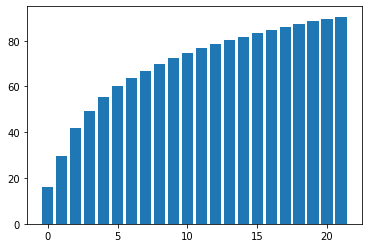

In [18]:
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " features explain around 90% of the variance. From 7129 features to ", k, sep='')

pca = PCA(n_components=k)
X_train.pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

[]

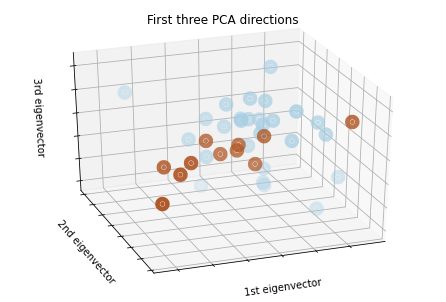

In [23]:
pca3 = PCA(n_components=3).fit(X_train)
X_train_reduced = pca3.transform(X_train)

plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2], c = y_train.iloc[:,1], cmap = plt.cm.Paired, linewidths=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

Text(0.5, 1.0, '2D Transformation of the Above Graph ')

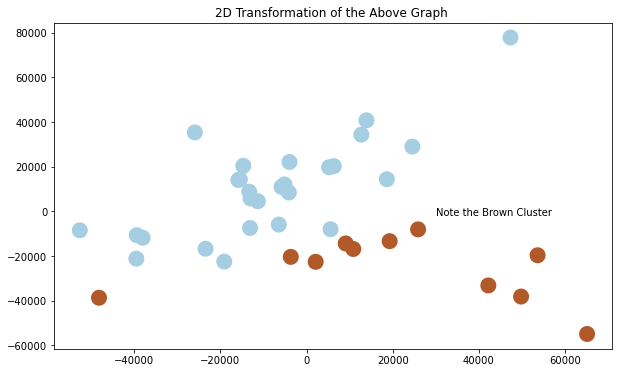

In [24]:
fig = plt.figure(1, figsize = (10, 6))
plt.scatter(X_train_reduced[:, 0],  X_train_reduced[:, 1], c = y_train.iloc[:,1], cmap = plt.cm.Paired, linewidths=10)
plt.annotate('Note the Brown Cluster', xy = (30000,-2000))
plt.title("2D Transformation of the Above Graph ")

In [21]:
print("Simply predicting everything as acute lymphoblastic leukemia (ALL) results in an accuracy of ", round(1 - np.mean(y_test.iloc[:,1]), 3), ".", sep = '')

Simply predicting everything as acute lymphoblastic leukemia (ALL) results in an accuracy of 0.588.


K-means accuracy: 0.294


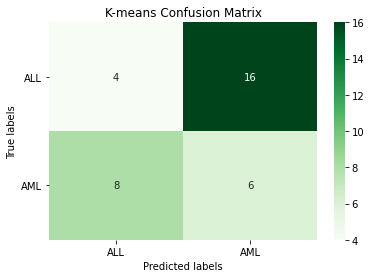

In [23]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train_scl)
km_pred = kmeans.predict(X_test_scl)

print('K-means accuracy:', round(accuracy_score(y_test.iloc[:,1], km_pred), 3))

cm_km = confusion_matrix(y_test.iloc[:,1], km_pred)

ax = plt.subplot()
sns.heatmap(cm_km, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('K-means Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Naive Bayes accuracy: 0.912


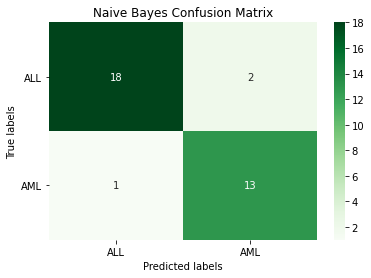

In [24]:
# Create a Gaussian classifier
nb_model = GaussianNB()

nb_model.fit(X_train, y_train.iloc[:,1])

nb_pred = nb_model.predict(X_test)

print('Naive Bayes accuracy:', round(accuracy_score(y_test.iloc[:,1], nb_pred), 3))

cm_nb =  confusion_matrix(y_test.iloc[:,1], nb_pred)

ax = plt.subplot()
sns.heatmap(cm_nb, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Naive Bayes Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Best Parameters:
 {'C': 0.1, 'penalty': 'l1'}
Logistic Regression accuracy: 0.971


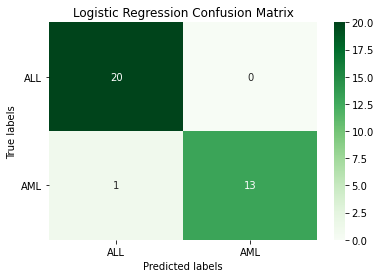

In [25]:
log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10], 
                 'penalty': ['l1', 'l2']}

log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator, 
                  param_grid=log_grid, 
                  cv=3,
                  scoring='accuracy')

log_model.fit(X_train, y_train.iloc[:,1])

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(X_test)

print('Logistic Regression accuracy:', round(accuracy_score(y_test.iloc[:,1], log_pred), 3))

cm_log =  confusion_matrix(y_test.iloc[:,1], log_pred)

ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Logistic Regression Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Best Parameters:
 {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'linear'}
SVM accuracy: 0.941


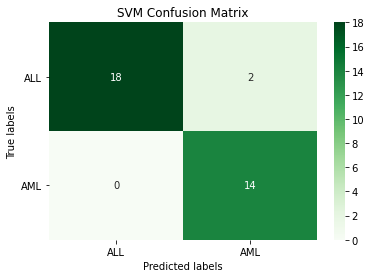

In [26]:
# Parameter grid
svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10], "kernel": ["linear", "rbf", "poly"], "decision_function_shape" : ["ovo", "ovr"]} 

# Create SVM grid search classifier
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)

# Train the classifier
svm_grid.fit(X_train_pca, y_train.iloc[:,1])

print("Best Parameters:\n", svm_grid.best_params_)

# Select best svc
best_svc = svm_grid.best_estimator_

# Make predictions using the optimised parameters
svm_pred = best_svc.predict(X_test_pca)

print('SVM accuracy:', round(accuracy_score(y_test.iloc[:,1], svm_pred), 3))

cm_svm =  confusion_matrix(y_test.iloc[:,1], svm_pred)

ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('SVM Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

Best Parameters:
 {'bootstrap': False, 'max_features': 0.6, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 60}
Random Forest accuracy: 0.912


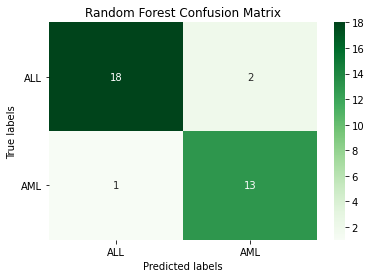

In [27]:
# Hyperparameters search grid 
rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [60, 70, 80, 90, 100],
         'max_features': [0.6, 0.65, 0.7, 0.75, 0.8],
         'min_samples_leaf': [8, 10, 12, 14],
         'min_samples_split': [3, 5, 7]
        }

# Instantiate random forest classifier
rf_estimator = RandomForestClassifier(random_state=0)

# Create the GridSearchCV object
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=3, scoring='accuracy')

# Fine-tune the hyperparameters
rf_model.fit(X_train, y_train.iloc[:,1])

print("Best Parameters:\n", rf_model.best_params_)

# Get the best model
rf_model_best = rf_model.best_estimator_

# Make predictions using the optimised parameters
rf_pred = rf_model_best.predict(X_test)

print('Random Forest accuracy:', round(accuracy_score(y_test.iloc[:,1], rf_pred), 3))

cm_rf = confusion_matrix(y_test.iloc[:,1], rf_pred)

ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Random Forest Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

In [30]:
xgb_grid_params = {'max_depth': [3, 4, 5, 6, 7, 8, 10, 12],
               'min_child_weight': [1, 2, 4, 6, 8, 10, 12, 15],
               'n_estimators': [40, 50, 60, 70, 80, 90, 100, 110, 120, 130],
               'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]}

fixed_params = {'random_state': 0,
                'n_jobs': -1}

xgb_model = GridSearchCV(xgb.XGBClassifier(**fixed_params), 
                       param_grid = xgb_grid_params, 
                       scoring = 'accuracy',
                       cv = 3)

xgb_model.fit(X_train_pca, y_train.iloc[:,1])

print("Best Parameters:\n", xgb_model.best_params_)

# Get the best model
xgb_model_best = xgb_model.best_estimator_

# Make predictions using the optimised parameters
xgb_pred = xgb_model_best.predict(X_test_pca)

print('XGB (PCA with Grid Search) accuracy:', round(accuracy_score(y_test.iloc[:,1], xgb_pred), 3))

cm_xgb = confusion_matrix(y_test.iloc[:,1], xgb_pred)

ax = plt.subplot()
sns.heatmap(cm_xgb, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('XGB (PCA with Grid Search) Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

NameError: name 'xgb' is not defined